In [85]:
import pandas as pd
import numpy as np

In [86]:
import warnings
warnings.filterwarnings("ignore")

# 13  Пайплайн ML-модели

In [87]:
# Предсказание стоимости подержанных машин по их различным характеристикам.

# План решения задачи такой:

# загрузка данных и их первичный анализ
# разведочный анализ данных
# построение базовой модели (baseline)
# улучшение модели
# получение итогового предсказания и интерпретация результатов

# Used car's price prediction

# Шаг 1: загрузка и первичный анализ данных

## Описание задачи

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?!  
Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

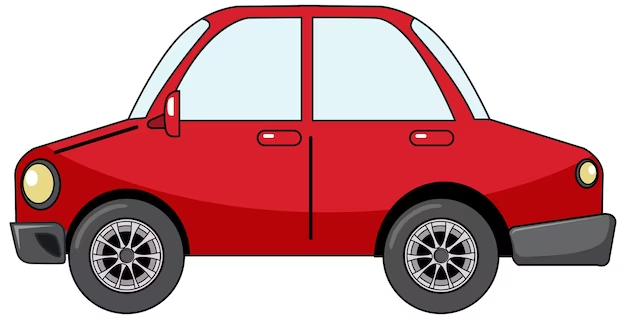

## Импорт библиотек, константы и загрузка данных

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from urllib.parse import urlencode

In [89]:
RANDOM_STATE = 42

Будем работать с данными `train.csv`.

Когда финальная модель будет готова, с помощью нее предскажем цены на машины из файла `test.csv` (там ответов нет).

In [90]:
TEST = "https://www.dropbox.com/s/asf4b1z1yme5o7u/cars_test.csv?dl=1"
TRAIN = "https://www.dropbox.com/s/qk4b79i7c078sxm/cars_train.csv?dl=1"

In [91]:
data = pd.read_csv(TRAIN)

In [92]:
data.shape

(396212, 15)

In [93]:
data.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,sellingprice
0,2013,Dodge,Dart,Limited,Sedan,automatic,1c3cdfca5dd293552,mo,4.6,13957.0,gray,black,chrysler capital,Wed Jan 21 2015 02:30:00 GMT-0800 (PST),14500
1,2014,Honda,Civic,LX,Sedan,automatic,19xfb2f56ee228781,ca,5.0,2401.0,gray,black,"ahfc/honda lease trust/hvt, inc.",Thu Feb 26 2015 04:00:00 GMT-0800 (PST),16500
2,2012,Chevrolet,Traverse,LT,suv,automatic,1gnkrged3cj244704,wi,2.4,70046.0,white,black,capital one auto finance,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT),13700


Выделим целевую переменную `sellingprice` в отдельную переменную `y`, а `X` - матрица объект-признак.

In [94]:
X = data.drop('sellingprice', axis=1)
y = data['sellingprice']

**Описание данных**

**_Признаки_**
- `year` - год производства
- `make` - производитель
- `model` - модель
- `trim` - модификация
- `body` - тип кузова
- `transmission` - тип КПП
- `vin` - идентификатор (вин)
- `state` - штат регистрации
- `condition` - состояние по шкале (1-5)
- `odometer` - пробег в милях
- `color` - цвет кузова
- `interior` - цвет интерьера
- `seller` - продавец
- `saledate` - дата продажи

**_Целевой признак_**
- `sellingprice` - стоимость продажи

In [95]:
X.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2013,Dodge,Dart,Limited,Sedan,automatic,1c3cdfca5dd293552,mo,4.6,13957.0,gray,black,chrysler capital,Wed Jan 21 2015 02:30:00 GMT-0800 (PST)
1,2014,Honda,Civic,LX,Sedan,automatic,19xfb2f56ee228781,ca,5.0,2401.0,gray,black,"ahfc/honda lease trust/hvt, inc.",Thu Feb 26 2015 04:00:00 GMT-0800 (PST)
2,2012,Chevrolet,Traverse,LT,suv,automatic,1gnkrged3cj244704,wi,2.4,70046.0,white,black,capital one auto finance,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
3,2014,Nissan,Versa Note,1.6 SV,Hatchback,automatic,3n1ce2cp9el407766,fl,2.6,23415.0,gray,black,florida auto financial group,Tue Feb 17 2015 01:30:00 GMT-0800 (PST)
4,2014,Nissan,Versa,1.6 SV,sedan,automatic,3n1cn7ap4el813308,il,3.4,17040.0,blue,black,nissan motor acceptance corporation,Thu Jun 04 2015 03:00:00 GMT-0700 (PDT)


Посмотрим на типы колонок и число пропущенных значений в них.

In [96]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396212 entries, 0 to 396211
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          396212 non-null  int64  
 1   make          388993 non-null  object 
 2   model         388922 non-null  object 
 3   trim          388727 non-null  object 
 4   body          386883 non-null  object 
 5   transmission  350025 non-null  object 
 6   vin           396212 non-null  object 
 7   state         396212 non-null  object 
 8   condition     387759 non-null  float64
 9   odometer      396151 non-null  float64
 10  color         395679 non-null  object 
 11  interior      395679 non-null  object 
 12  seller        396212 non-null  object 
 13  saledate      396212 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 42.3+ MB


Посмотрим на числовые признаки

In [97]:
X.describe()

,year,condition,odometer
count,396212.000000,387759.000000,396151.000000
mean,2010.041442,3.425687,68336.479029
std,3.977384,0.949871,53559.280598
min,1982.000000,1.000000,1.000000
25%,2007.000000,2.700000,28259.000000
50%,2012.000000,3.600000,52113.000000
75%,2013.000000,4.200000,99300.000000
max,2015.000000,5.000000,999999.000000


Посмотрим на категориальные признаки

In [98]:
X.describe(include='object')

,make,model,trim,body,transmission,vin,state,color,interior,seller,saledate
count,388993,388922,388727,386883,350025,396212,396212,395679,395679,396212,396212
unique,91,949,1899,83,2,396212,38,20,17,12530,3544
top,Ford,Altima,Base,Sedan,automatic,1c3cdfca5dd293552,fl,black,black,nissan-infiniti lt,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
freq,66391,13969,39538,141921,337646,1,59164,78576,173230,14323,3783


Признак `vin` это уникальный идентификатор машины, поэтому удалим его.

In [99]:
X.drop('vin', axis=1, inplace=True)

# Разведочный анализ данных

## Заполнение пропусков

Заполним пропуски в числовых столбцах средним значением, а в категориальных - пустой категорией

In [100]:
for c in X.columns:
    if X[c].dtype == 'object':
          X[c] = X[c].fillna("")

In [101]:
for c in X.columns:
    if X[c].dtype != 'object':
          mean = np.mean(X[c])
          X[c] = X[c].fillna(mean)

## Обработка категориальных признаков - 1

Посмотрим на количество значений в каждой категории

In [102]:
for c in X.columns:
    if X[c].dtype == 'object':
          print(c, len(X[c].unique()))

make 92
model 950
trim 1900
body 84
transmission 3
state 38
color 21
interior 18
seller 12530
saledate 3544


В saledate очень много различных значений. Посмотрим почему.

In [103]:
X[['year','saledate']]

,year,saledate
0,2013,Wed Jan 21 2015 02:30:00 GMT-0800 (PST)
1,2014,Thu Feb 26 2015 04:00:00 GMT-0800 (PST)
2,2012,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
3,2014,Tue Feb 17 2015 01:30:00 GMT-0800 (PST)
4,2014,Thu Jun 04 2015 03:00:00 GMT-0700 (PDT)
...,...,...
396207,2013,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
396208,2009,Mon Jun 08 2015 02:00:00 GMT-0700 (PDT)
396209,2004,Tue Jan 20 2015 02:30:00 GMT-0800 (PST)
396210,2013,Fri Dec 19 2014 11:45:00 GMT-0800 (PST)


Обработаем saledate:
* сделаем признак `car_age` - возраст машины в годах
* сделаем признак `date` - месяц + год продажи машины (категориальный)

Исходный признак `saledate` удалим

In [104]:
X['car_age'] = X['saledate'].apply(lambda x: int(x.split(" ")[3])) - X['year']
X['date'] = X['saledate'].apply(lambda x: x.split(" ")[1]+x.split(" ")[3])

X = X.drop('saledate', axis=1)

## Корреляционные матрицы

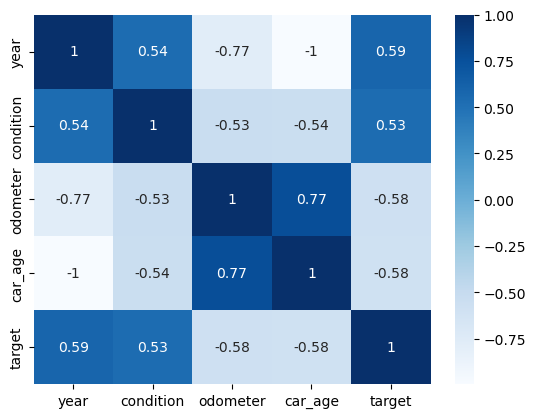

In [105]:
import seaborn as sb

X['target'] = y

cols = X.columns[X.dtypes != 'object']

corr = X[cols].corr()
sb.heatmap(corr, cmap="Blues", annot=True)

X = X.drop('target', axis=1)

Все числовые признаки важны, запомним это

Посмотрим на аналог корреляции категориальных признаков

In [106]:
import association_metrics as am

XC = X.apply(
        lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC)

cramersv.fit()

,make,model,trim,body,transmission,state,color,interior,seller,date
make,1.000000,0.942073,0.768825,0.189035,0.161258,0.080016,0.085875,0.108237,0.405386,0.059136
model,0.942073,1.000000,0.552843,0.615147,0.310298,0.120689,0.145266,0.181734,0.287182,0.086036
trim,0.768825,0.552843,1.000000,0.437450,0.291284,0.131441,0.139243,0.210486,0.267798,0.099165
body,0.189035,0.615147,0.437450,1.000000,0.171188,0.054380,0.070882,0.073898,0.251710,0.298083
transmission,0.161258,0.310298,0.291284,0.171188,1.000000,0.377115,0.063472,0.066053,0.394181,0.031898
state,0.080016,0.120689,0.131441,0.054380,0.377115,1.000000,0.064536,0.062192,0.679166,0.081021
color,0.085875,0.145266,0.139243,0.070882,0.063472,0.064536,1.000000,0.259053,0.233966,0.018536
interior,0.108237,0.181734,0.210486,0.073898,0.066053,0.062192,0.259053,1.000000,0.258849,0.061795
seller,0.405386,0.287182,0.267798,0.251710,0.394181,0.679166,0.233966,0.258849,1.000000,0.286704
date,0.059136,0.086036,0.099165,0.298083,0.031898,0.081021,0.018536,0.061795,0.286704,1.000000


Признаки make и model сильно связаны, поэтому уберем make как менее информативный

In [107]:
X = X.drop('make', axis=1)

Как посмотреть влияние категориального признака на целевую переменную? Здесь лучше всего поможет scatterplot

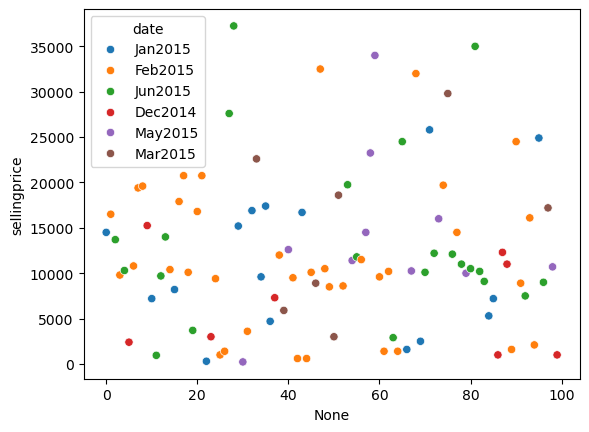

In [108]:
import seaborn as sns

sns.scatterplot(data=X.iloc[:100], x=X.iloc[:100].index, y=y[:100], hue='date');

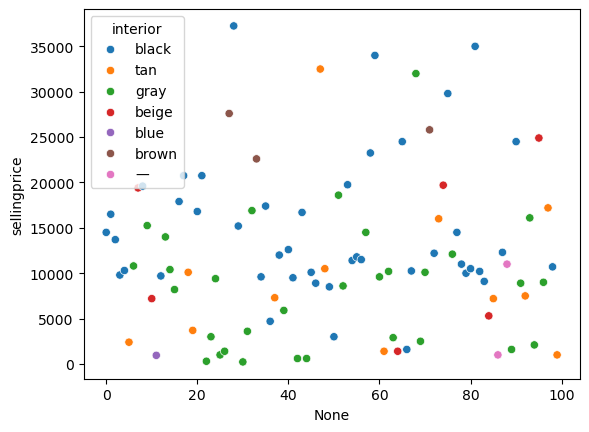

In [109]:
sns.scatterplot(data=X.iloc[:100], x=X.iloc[:100].index, y=y[:100], hue='interior');

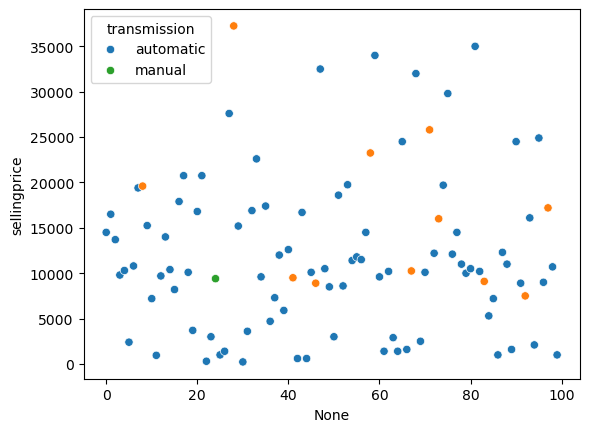

In [110]:
sns.scatterplot(data=X.iloc[:100], x=X.iloc[:100].index, y=y[:100], hue='transmission');

Посмотрим на распределение целевой переменной

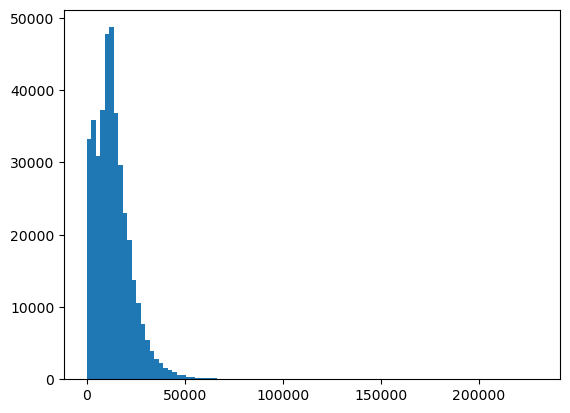

In [111]:
plt.hist(y, bins=100);

Пока мы не будем ничего делать с этим распределением, но известно, что с распределениями, отличными от нормального, большинству моделей сложно работать.

Поэтому при улучшении качества базового решения мы преобразуем это распределение.

## Поиск аномальных значений

In [112]:
cat_cols = X.columns[X.dtypes == 'object']
num_cols = X.columns[X.dtypes != 'object']

year


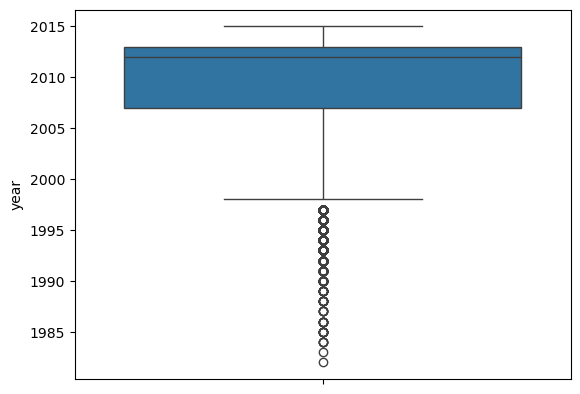

condition


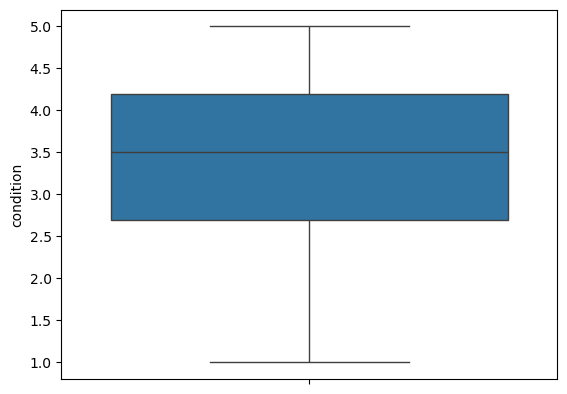

odometer


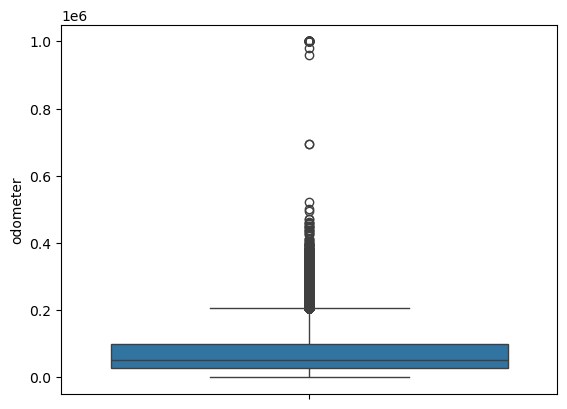

car_age


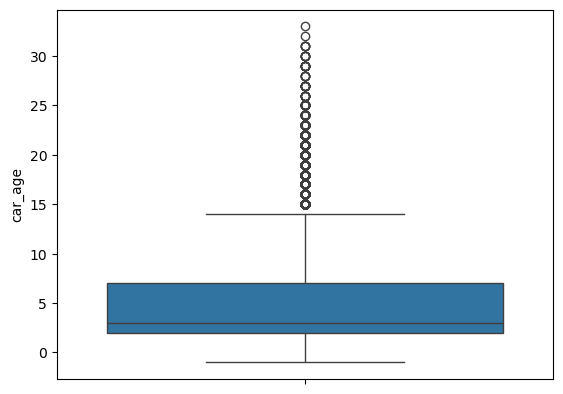

In [113]:
for col in num_cols:
    print(col)
    sb.boxplot(X[col])
    plt.show();

In [114]:
X[X['odometer'] > 800000][['car_age','odometer']]

,car_age,odometer
8651,8,999999.0
26775,8,999999.0
39643,8,999999.0
59125,8,999999.0
69969,9,999999.0
70028,10,999999.0
78649,9,999999.0
90539,14,999999.0
94884,2,999999.0
105833,8,999999.0


Выкинем машины младше 10 лет, проехавшие 1_000_000 миль - это почти точно выбросы.

In [115]:
Xnew = X[~((X.car_age < 10) & (X.odometer > 800_000))]
ynew = y[~((X.car_age < 10) & (X.odometer > 800_000))]

Xnew = Xnew.drop('car_age', axis=1)